In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)


C:\Users\kmura\AppData\Local\Programs\Python\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

In [4]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]


In [5]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)


# Generator


In [6]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


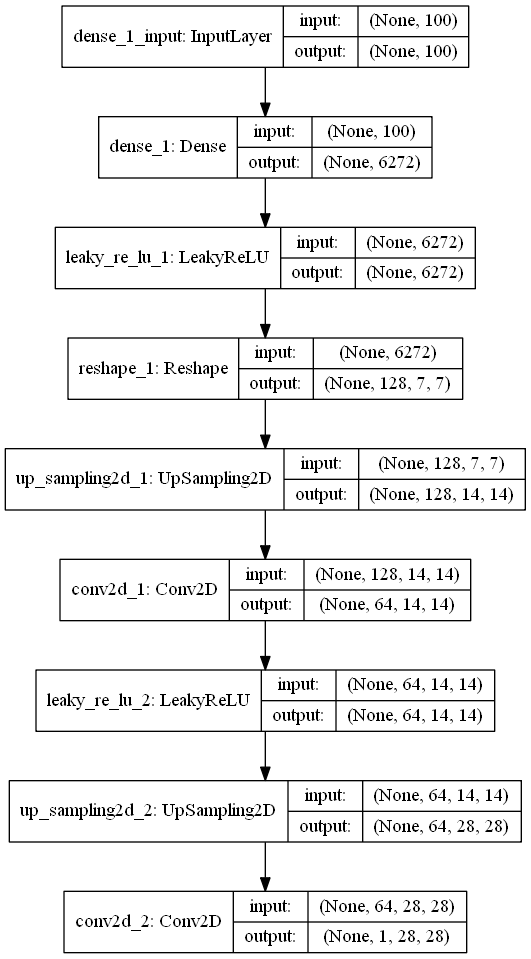

In [7]:
from keras.utils import plot_model

plot_model(generator,to_file='generator_demo.png',show_shapes=True)
from IPython.display import Image
Image("generator_demo.png")

# Discriminator

In [8]:

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


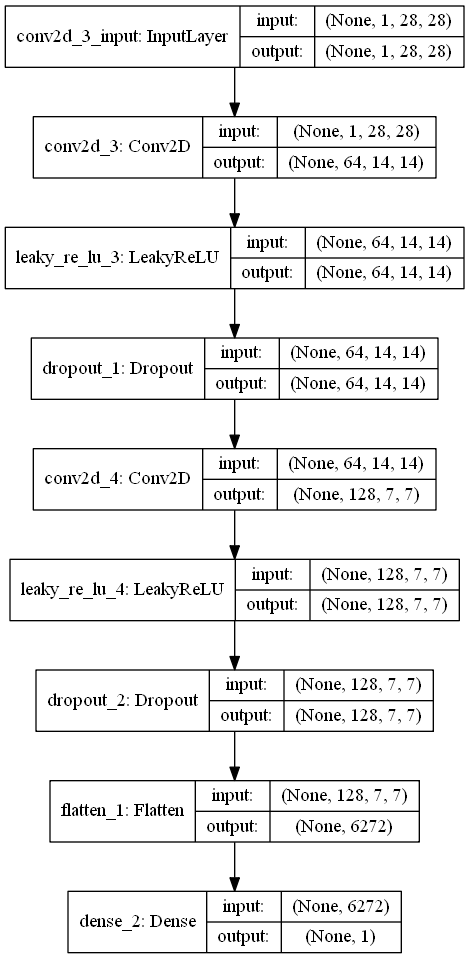

In [9]:
from keras.utils import plot_model

plot_model(discriminator,to_file='discriminator_demo.png',show_shapes=True)
from IPython.display import Image
Image("discriminator_demo.png")

# Combined network


In [9]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


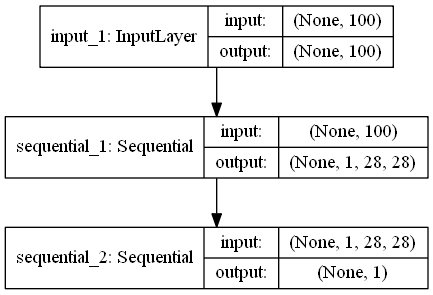

In [10]:
from keras.utils import plot_model

plot_model(gan,to_file='gan_demo.png',show_shapes=True)
from IPython.display import Image
Image("gan_demo.png")

In [9]:
dLosses = []
gLosses = []


# Plot the loss from each batch


In [10]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)


# Create a wall of generated MNIST images


In [11]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)


# Save the generator and discriminator networks (and weights) for later use


In [12]:
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)


In [25]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] // batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        print(batchCount)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)



In [26]:
if __name__ == '__main__':
    train(50, 128)

Epochs: 50
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
468
--------------- Epoch 2 ---------------
468
--------------- Epoch 3 ---------------
468
--------------- Epoch 4 ---------------
468
--------------- Epoch 5 ---------------
468
--------------- Epoch 6 ---------------
468
--------------- Epoch 7 ---------------
468
--------------- Epoch 8 ---------------
468
--------------- Epoch 9 ---------------
468
--------------- Epoch 10 ---------------
468
--------------- Epoch 11 ---------------
468
--------------- Epoch 12 ---------------
468
--------------- Epoch 13 ---------------
468
--------------- Epoch 14 ---------------
468
--------------- Epoch 15 ---------------
468
--------------- Epoch 16 ---------------
468
--------------- Epoch 17 ---------------
468
--------------- Epoch 18 ---------------
468
--------------- Epoch 19 ---------------
468
--------------- Epoch 20 ---------------
468
--------------- Epoch 21 ---------------
468
--------------